In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
tfds.disable_progress_bar()

In [5]:
embedding_layer = tf.keras.layers.Embedding(1000, 5)

In [6]:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

array([[-0.02474276,  0.00817237,  0.03389159,  0.02612631,  0.02959469],
       [ 0.02291865,  0.02899933, -0.03737419, -0.04788343, -0.02234489],
       [ 0.00180644, -0.01279293,  0.00712017, -0.0388446 , -0.04248589]],
      dtype=float32)

In [7]:
result = embedding_layer(tf.constant([[0, 1, 2], [3, 4, 5]]))
result.shape

TensorShape([2, 3, 5])

In [8]:
### Learning embeddings from scratch
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    with_info=True,
    as_supervised=True
)

Shuffling and writing examples to /Users/shankar/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteZ0MG9R/imdb_reviews-train.tfrecord
Shuffling and writing examples to /Users/shankar/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteZ0MG9R/imdb_reviews-test.tfrecord
Shuffling and writing examples to /Users/shankar/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteZ0MG9R/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /Users/shankar/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [10]:
# SubwordTextEncoder

encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [11]:
train_data

<DatasetV1Adapter shapes: ((None,), ()), types: (tf.int64, tf.int64)>

In [13]:
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=([None], []))
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=([None], []))

In [17]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[  19,  314,   18, ...,    0,    0,    0],
       [  19, 2122,  457, ...,    0,    0,    0],
       [  62,    9,  236, ...,    0,    0,    0],
       ...,
       [ 373,    6,   82, ...,    0,    0,    0],
       [ 156,  151, 7968, ...,    0,    0,    0],
       [2307, 1031,  800, ...,    0,    0,    0]])

In [19]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, embedding_dim), 
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, 
    validation_steps=20
)

Epoch 1/10
2500/2500 [==============================] - 12s 5ms/step - loss: 0.5351 - accuracy: 0.6710 - val_loss: 0.4380 - val_accuracy: 0.8100
Epoch 2/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2948 - accuracy: 0.8766 - val_loss: 0.2996 - val_accuracy: 0.8750
Epoch 3/10
2500/2500 [==============================] - 6s 3ms/step - loss: 0.2418 - accuracy: 0.9050 - val_loss: 0.3083 - val_accuracy: 0.8850
Epoch 4/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2066 - accuracy: 0.9210 - val_loss: 0.4073 - val_accuracy: 0.8450
Epoch 5/10
2500/2500 [==============================] - 6s 3ms/step - loss: 0.1841 - accuracy: 0.9302 - val_loss: 0.4507 - val_accuracy: 0.8600
Epoch 6/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.1647 - accuracy: 0.9387 - val_loss: 0.3683 - val_accuracy: 0.8450
Epoch 7/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1511 - accuracy: 0.9453 - val_loss: 0.4495 - val_accuracy

In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (15, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

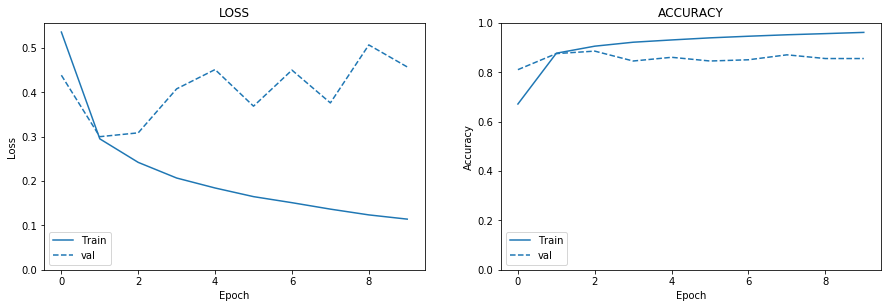

In [25]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(
            history.epoch, 
            history.history[metric], 
            color=colors[0], 
            label='Train'
        )
        plt.plot(
            history.epoch, 
            history.history['val_' + metric], 
            color=colors[0], 
            linestyle="--", 
            label='val'
        )
        plt.title(metric.upper())
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if(metric == 'loss'):
            plt.ylim([0, plt.ylim()[1]])
        elif(metric == 'auc'):
            plt.ylim([0, 1])
        else:
            plt.ylim([0, 1])
        plt.legend()
        
plot_metrics(history)

In [26]:
e = model.layers[0]
print(f"Layer Count: {len(model.layers)}")

Layer Count: 4


In [28]:
weights = e.get_weights()[0]
print(weights.shape)

(8185, 16)


In [29]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
    vec = weights[num + 1]
    out_m.write(word + '\n')
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    
out_v.close()
out_m.close()

## Text Classification

In [31]:
print(f'Vocabulary size: {encoder.vocab_size}')

Vocabulary size: 8185


In [33]:
sample_string = "Hello Tensorflow"
encoded_string = encoder.encode(sample_string)
print(f"Encoded String is {encoded_string}")

Encoded String is [4025, 222, 6307, 2327, 2934]


In [34]:
original_string = encoder.decode(encoded_string)
print(f"Original String is {original_string}")

Original String is Hello Tensorflow


In [35]:
for index in encoded_string:
    print(f"{index} ---> {encoder.decode([index])}")

4025 ---> Hell
222 ---> o 
6307 ---> Ten
2327 ---> sor
2934 ---> flow


In [38]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [43]:
# Data Preparation
# train_data, test_data
train_dataset = (train_data.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([None], [])))
test_dataset = (test_data.padded_batch(BATCH_SIZE, padded_shapes=([None], [])))

In [42]:
# train_dataset = (train_data.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE))
# test_dataset = (test_data.padded_batch(BATCH_SIZE))

TypeError: padded_batch() missing 1 required positional argument: 'padded_shapes'

In [44]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [45]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)

Epoch 1/10
      4/Unknown - 7s 2s/step - loss: 0.6932 - accuracy: 0.4727